In [1]:
from functools import partial

import matplotlib.pyplot as plt

from superfv import EulerSolver, OutputLoader, plot_2d_slice
from superfv.initial_conditions import gresho_vortex

In [2]:
N = 96
gamma = 5 / 3
nsteps = 1000

v0 = 5.0
M_max = 0.001

In [3]:
common = dict(PAD={"rho": (0, None), "P": (0, None)})
apriori = dict(ZS=True, lazy_primitives="adaptive", **common)
aposteriori = dict(
    MOOD=True,
    face_fallback=False,
    lazy_primitives="full",
    MUSCL_limiter="PP2D",
    **common,
)
aposteriori1 = dict(cascade="muscl", max_MOOD_iters=1, **aposteriori)
aposteriori2 = dict(cascade="muscl1", max_MOOD_iters=2, **aposteriori)
aposteriori3 = dict(cascade="muscl1", max_MOOD_iters=3, **aposteriori)

config1 = dict(p=7)
config2 = dict(p=7, GL=True, **apriori)

In [ ]:
sim1 = EulerSolver(
    ic=partial(gresho_vortex, gamma=gamma, M_max=M_max, v0=v0),
    gamma=gamma,
    nx=N,
    ny=N,
    cupy=True,
    **config1,
)

sim2 = EulerSolver(
    ic=partial(gresho_vortex, gamma=gamma, M_max=M_max, v0=v0),
    gamma=gamma,
    nx=N,
    ny=N,
    cupy=True,
    **config2,
)

In [ ]:
sim1.run(
    n=nsteps,
    allow_overshoot=True,
    q_max=2,
    muscl_hancock=config1.get("MUSCL", False),
    log_freq=100,
)

In [ ]:
sim2.run(
    n=nsteps,
    allow_overshoot=True,
    q_max=2,
    muscl_hancock=config2.get("MUSCL", False),
    log_freq=100,
)

In [10]:
sim1 = OutputLoader("/scratch/gpfs/jp7427/out/gresho-vortex/v0_5.0/p3/M_max_0.001/")
sim2 = OutputLoader("/scratch/gpfs/jp7427/out/gresho-vortex/v0_5.0/ZS3/M_max_0.001/")

Successfully read simulation output from "/scratch/gpfs/jp7427/out/gresho-vortex/v0_5.0/p3/M_max_0.001"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/gresho-vortex/v0_5.0/ZS3/M_max_0.001"


(<matplotlib.image.AxesImage at 0x1546cb25ccb0>,
 <matplotlib.colorbar.Colorbar at 0x15474bf1d340>)

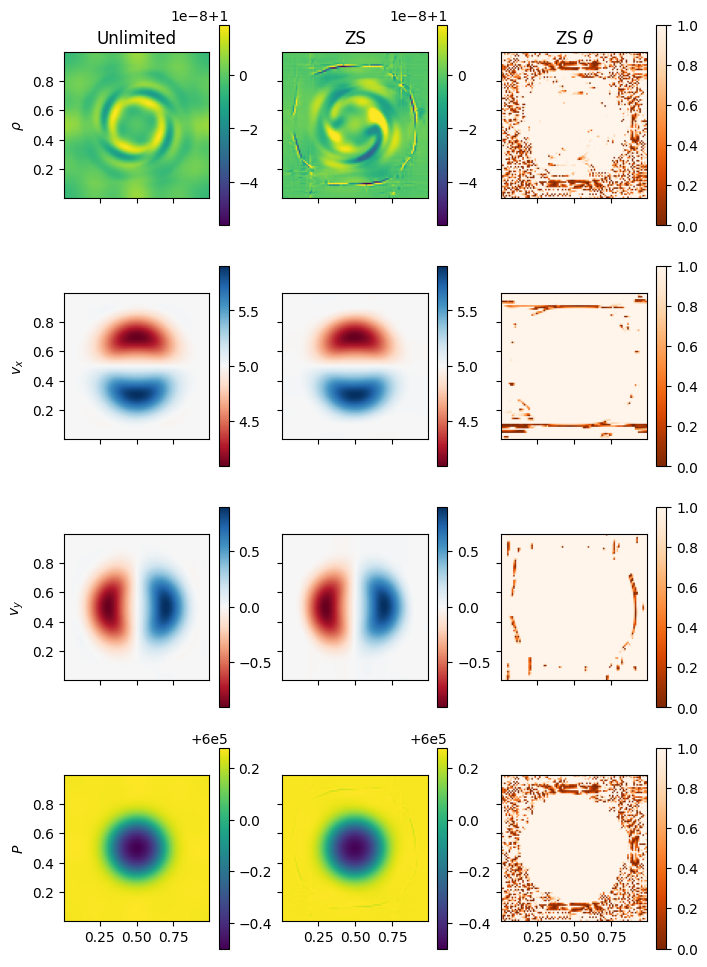

In [11]:
fig, axs = plt.subplots(4, 3, sharex=True, sharey=True, figsize=(8, 12))

axs[0, 0].set_ylabel(r"$\rho$")
axs[1, 0].set_ylabel(r"$v_x$")
axs[2, 0].set_ylabel(r"$v_y$")
axs[3, 0].set_ylabel(r"$P$")
axs[0, 0].set_title("Unlimited")
axs[0, 1].set_title("ZS")
axs[0, 2].set_title(r"ZS $\theta$")

idx = sim1.variable_index_map
rho_min = min(sim.snapshots[-1]["w"][idx("rho")].min() for sim in [sim1, sim2])
rho_max = min(sim.snapshots[-1]["w"][idx("rho")].max() for sim in [sim1, sim2])
vx_min = min(sim.snapshots[-1]["w"][idx("vx")].min() for sim in [sim1, sim2])
vx_max = min(sim.snapshots[-1]["w"][idx("vx")].max() for sim in [sim1, sim2])
vy_min = min(sim.snapshots[-1]["w"][idx("vy")].min() for sim in [sim1, sim2])
vy_max = min(sim.snapshots[-1]["w"][idx("vy")].max() for sim in [sim1, sim2])
P_min = min(sim.snapshots[-1]["w"][idx("P")].min() for sim in [sim1, sim2])
P_max = min(sim.snapshots[-1]["w"][idx("P")].max() for sim in [sim1, sim2])

rho_style = dict(cell_averaged=True, colorbar=True, vmin=rho_min, vmax=rho_max)
vx_style = dict(
    cell_averaged=True, colorbar=True, vmin=vx_min, vmax=vx_max, cmap="RdBu"
)
vy_style = dict(
    cell_averaged=True, colorbar=True, vmin=vy_min, vmax=vy_max, cmap="RdBu"
)
P_style = dict(cell_averaged=True, colorbar=True, vmin=P_min, vmax=P_max)

plot_2d_slice(sim1, axs[0, 0], "rho", **rho_style)
plot_2d_slice(sim1, axs[1, 0], "vx", **vx_style)
plot_2d_slice(sim1, axs[2, 0], "vy", **vy_style)
plot_2d_slice(sim1, axs[3, 0], "P", **P_style)

plot_2d_slice(sim2, axs[0, 1], "rho", **rho_style)
plot_2d_slice(sim2, axs[1, 1], "vx", **vx_style)
plot_2d_slice(sim2, axs[2, 1], "vy", **vy_style)
plot_2d_slice(sim2, axs[3, 1], "P", **P_style)

theta_style = dict(
    theta=True, visualization=False, vmin=0, vmax=1, cmap="Oranges_r", colorbar=True
)
plot_2d_slice(sim2, axs[0, 2], "rho", **theta_style)
plot_2d_slice(sim2, axs[1, 2], "vx", **theta_style)
plot_2d_slice(sim2, axs[2, 2], "vy", **theta_style)
plot_2d_slice(sim2, axs[3, 2], "P", **theta_style)

In [8]:
fig.savefig("gresho_debug.pdf", bbox_inches="tight")